Written by Joao Rodrigues

July 2020

Example: Implements a simple, spatially unresolved, 2D harmonic oscillator. Calculates the steady-state as a function of increasing pump power, and demonstrated Bose-Einstein condensation

Note: All parameters are defined in SI units

In [4]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

### Cavity parameters

In [5]:
mode_spacing = 1.0*1e-9          # meters
lambda0 = 570*1e-9               # meters
n_modes = 10                     # number of non-degenerate modes
dye_concentration = 2.0          # in mM, with 1 mM=1mol/m^3
n = 1.43                         # index of refraction of the dye solution
L0 = 2.0*1e-6                    # meters
cavity_area = 20*20*(1e-6)**2    # meters^2

### Calculates the emission and absorption rates from experimental data, for Rhodamine 6G

In [6]:
from PyPBEC.OpticalMedium.OpticalMedium import OpticalMedium
lambdas = -mode_spacing*np.arange(0, n_modes, 1) + lambda0
mode_degeneracy = np.arange(1, n_modes+1, 1)
R6G = OpticalMedium(optical_medium="Rhodamine6G")
absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, dye_concentration=dye_concentration, n=n)

### Normalizes all rates to the cavity loss rate, for better numerical performance

In [7]:
cavity_loss_rate = 1.0/(10*1e-12)    # in s^-1

cavity_loss_rates = np.ones(n_modes)
emission_rates = emission_rates / cavity_loss_rate
absorption_rates = absorption_rates / cavity_loss_rate

### Defines the cavity

In [8]:
Gamma_down = 100.0

# Properties of the photonic modes
from PyPBEC.Cavity import Cavity
g = np.ones((n_modes, 1))
cavity = Cavity(M=n_modes, J=1)
cavity.set_cavity_loss_rates(rates=cavity_loss_rates)
cavity.set_cavity_emission_rates(rates=emission_rates)
cavity.set_cavity_absorption_rates(rates=absorption_rates)

# Properties of the molecular modes
cavity.set_reservoir_decay_rates(rates=[Gamma_down])
molecular_population = int(sc.Avogadro*dye_concentration*0.5*L0*cavity_area)
cavity.set_reservoir_population(population=[molecular_population])

# Coupling between photonic and molecular modes
cavity.set_coupling_terms(coupling_terms=g)

### Defines the pump values

In [9]:
pump_value_min = 1.0
pump_value_max = 10000.0
n_pump_values = 40

delta_p = (pump_value_max/pump_value_min)**(1/n_pump_values)-1
pumps = [(1+delta_p)**i*pump_value_min for i in range(0, n_pump_values)]

### Solves the steady-state

In [10]:
from PyPBEC.Solver import SteadyState
from tqdm import tqdm
populations = list()
for pump in tqdm(pumps):
    # loads the pump onto the cavity object
    cavity.set_reservoir_pump_rates(rates=[pump])
    
    # Steady-state solver
    solver_steadystate = SteadyState(cavity_obj=cavity, ANNEALING=True)
    
    # Defines the initial guess
    solver_steadystate.set_initial_photons(initial_photons=np.array(np.zeros(cavity.M), dtype=int))
    solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=[0])  
    
    # Calls the solver
    solved_cavity_steadystate = solver_steadystate.solve()
    
    # Sums the populations over the mode degeneracy
    steady_state_photon_population = [np.sum(solved_cavity_steadystate.photons[:,np.where(mode_degeneracy==mode_number)[0]], 1) 
        for mode_number in list(set(list(mode_degeneracy)))]
    steady_state_photon_population = np.transpose(np.array(steady_state_photon_population, dtype=float))
    
    # Appends
    populations.append(steady_state_photon_population)
populations = np.array(populations)

100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


### Plots the results

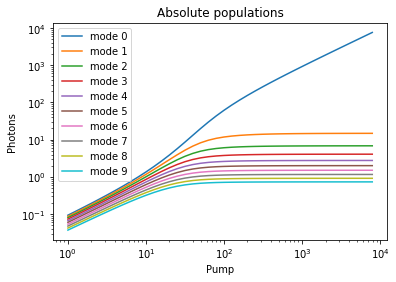

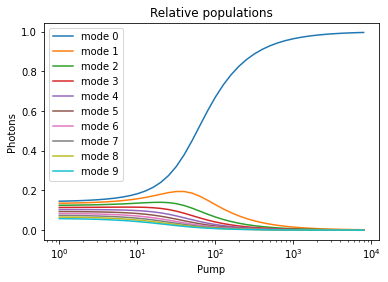

In [11]:
populations = np.squeeze(populations)

[plt.plot(pumps, populations[:,i], label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.yscale("log")
plt.title("Absolute populations")
plt.show()

[plt.plot(pumps, populations[:,i]/np.sum(populations,1), label="mode {0}".format(i)) for i in range(0, populations.shape[1])]
plt.legend()
plt.xlabel("Pump")
plt.xscale("log")
plt.ylabel("Photons")
plt.title("Relative populations")
plt.show()